In [1]:
!pip install alibi --quiet

In [1]:
##importing the libraries needed
import numpy as np
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs  
from math import floor, ceil
import sklearn as sk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Bidirectional, LSTM,Masking,Embedding
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import cross_validate,train_test_split,GridSearchCV
from sklearn.preprocessing import normalize
from tensorflow.keras.models import load_model 
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

import matplotlib.pyplot as pyplot
import seaborn as sns
import time
import json
import ast
import os



In [2]:
# EDIT HERE FOR OTHER COURSES
data_path = '../easy-fail/'
week_type = 'eq_week'
feature_types = [ 'boroujeni_et_al', 
                 'chen_cui',  'lalle_conati', 
                 'marras_et_al']
course = 'geomatique_003'
marras_et_al_id = feature_types.index('marras_et_al')
#akpinar_et_al_id = feature_types.index('akpinar_et_al')
remove_obvious = False

## Loading Data

In [21]:
def fillNaN(feature):
    shape = feature.shape
    feature_min = np.nanmin(feature.reshape(-1,shape[2]),axis=0)
    feature = feature.reshape(-1,shape[2])
    inds = np.where(np.isnan(feature))
    feature[inds] = np.take(feature_min.reshape(-1), inds[1])
    feature = feature.reshape(shape)
    return feature

In [22]:
# Loading the features
feature_list = {}

feature_type_list = []
for feature_type in feature_types:

    filepath = data_path + week_type + '-' + feature_type + '-' + course
    feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
    print(feature_current.shape)
    feature_norm = feature_current.reshape(-1,feature_current.shape[2] )
    print(feature_norm.shape)
    feature_type_list.append(pd.DataFrame(feature_norm))
feature_list[course] = feature_type_list

print('course: ', course)
print('week_type: ', week_type)
print('feature_type: ', feature_types)

(452, 15, 3)
(6780, 3)
(452, 15, 13)
(6780, 13)
(452, 15, 22)
(6780, 22)
(452, 15, 7)
(6780, 7)
course:  geomatique_003
week_type:  eq_week
feature_type:  ['boroujeni_et_al', 'chen_cui', 'lalle_conati', 'marras_et_al']


In [23]:
# Loading feature names
feature_names= dict()

for feature_type in feature_types:
    
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/settings.txt'
    file = open(filepath, "r")
    contents = file.read()
    dictionary = ast.literal_eval(contents)
    file.close()
    
    feature_type_name = dictionary['feature_names']
    
    if feature_type == 'akpinar_et_al':
        feature_type_name = [clean_akp_name(x) for x in feature_type_name]
        akp_mask = np.where(np.isin(feature_type_name, 
                 ["TotalClicks", "NumberSessions", "Time-video-sum", "Time-problem-sum",
                  'problem.check-problem.check-problem.check', 
                  'problem.check-problem.check-video.load', 
                  'video.play-video.play-video.play',
                  'video.play-video.pause-video.load',
                  'video.play-problem.check-problem.check',
                  'video.play-video.stop-video.play',
                  'video.pause-video.speedchange-video.play',
                  'video.stop-video.play-video.seek',
                  'video.stop-problem.check-video.load']))
        print(akp_mask)
        feature_type_name = list(np.array(feature_type_name)[akp_mask[0]])
        feature_list[course][akpinar_et_al_id] = feature_list[course][akpinar_et_al_id][akp_mask[0]]
        
    feature_names[feature_type] = feature_type_name
    print(feature_type, len(feature_type_name))

if remove_obvious: 
    # drop 'student shape', 'competency strength', 'competency alignment' in marras at al
    
    mask = np.where(np.isin(feature_names['marras_et_al'], 
                 ['StudentShape', 'CompetencyStrength', 'CompetencyAlignment']))
    
    new_marras = np.delete(np.array(feature_names['marras_et_al']), mask[0])
    feature_names['marras_et_al'] = new_marras
    
    new_features = feature_list[course][marras_et_al_id].drop(mask[0], axis=1)
    feature_list[course][marras_et_al_id] = new_features


boroujeni_et_al 3
chen_cui 13
lalle_conati 22
marras_et_al 7


In [24]:
# reformat feature names
# ex: time_sessions_<function sum at 0x7f3bd02cc9d0> -> time_sessions_sum
def clean_name(feature):
    id = feature.find('<')
    if id==-1:
        return feature
    fct = feature[id+9:id+14].strip()
    return feature[0:id]+fct


for k in feature_names.keys():
    cleaned = [clean_name(x) for x in feature_names[k]]
    feature_names[k] = cleaned

def clean_akp_name(feature):
    feature = feature.lower()
    if feature.find("(")!=-1:
        feature = feature[1:-1]
        feature = feature.replace(', ', '-')
    return feature

In [25]:
# TO CHANGE HERE THE WEEKS NUMBER
overwrite_num_weeks = 5

In [26]:
def load_labels(course):
    feature_type = "boroujeni_et_al"
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/feature_labels.csv'
    labels = pd.read_csv(filepath)['label-pass-fail']
    labels[labels.shape[0]] = 1
    return labels.values

def load_features(course, overwrite_num_weeks):
    feature_list = []
    selected_features = []
    total_features = set()
    num_weeks = 0
    num_features = 0
    for i,feature_type in enumerate(feature_types):
        filepath = data_path + week_type + '-' + feature_type + '-' + course 
        feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
        
        shape = feature_current.shape
#         print(shape)

        if remove_obvious and feature_type=='marras_et_al':
            feature_current = np.delete(feature_current, mask[0], axis=2)
        
        if feature_type=='akpinar_et_al':
            akp_mask_dl = np.delete(list(range(shape[2])), akp_mask[0])
            feature_current = np.delete(feature_current, akp_mask_dl, axis=2)
        
        shape = feature_current.shape
        print(shape)
        if i==0:
            num_weeks = shape[1]
            num_weeks=overwrite_num_weeks
            
        selected = np.arange(shape[2])
        # drop existed features
        exist_mask = []
        for i, name in enumerate(feature_names[feature_type]):
            if name in total_features:
                exist_mask.append(i)
            else:
                total_features.add(name)
        feature_current = np.delete(feature_current, exist_mask, axis=2)
        selected = np.delete(selected, exist_mask)
        
        nonNaN = (shape[0]*shape[1] - np.isnan(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0) > 0)
        feature_current = feature_current[:,:,nonNaN]
        selected = selected[nonNaN]
        feature_current = fillNaN(feature_current)
        nonZero = (abs(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0)>0)
        selected = selected[nonZero]
        feature_current = feature_current[:,:overwrite_num_weeks,nonZero]
#         print(len(feature_names[feature_type]), selected)
        selected_features.append(np.array(feature_names[feature_type])[[selected]])
        num_features += len(np.array(feature_names[feature_type])[[selected]])


        ##### Normalization with min-max. Added the artifical 1.001 max row for solving the same min max problem
        ##### for features with max=0 I added 1 instead of 1.001 of maximum

        features_min = feature_current.min(axis=0).reshape(-1)
        features_max = feature_current.max(axis=0)
        features_max = np.where(features_max==0,np.ones(features_max.shape),features_max)
        max_instance = 1.001*features_max
        feature_current = np.vstack([feature_current,max_instance.reshape((1,)+max_instance.shape)])
        features_max = features_max.reshape(-1)
        feature_norm = (feature_current.reshape(shape[0]+1,-1)-features_min)/(1.001*features_max-features_min)
        feature_current = feature_norm.reshape(-1,feature_current.shape[1],feature_current.shape[2] )

        num_features += feature_current.shape[2]
        print(num_features)
        feature_list.append(feature_current)
        
    features = np.concatenate(feature_list, axis=2)
    features_min = features.min(axis=0).reshape(-1)
    features_max = features.max(axis=0)
    features = features.reshape(features.shape[0],-1)
#     features = pd.DataFrame(features)
    
    SHAPE = features.shape
    # print(np.isnan(features[0,0,-1]))
    print(features.shape)
    print('course: ', course)
    print('week_type: ', week_type)
    print('feature_type: ', feature_types)
    print(selected_features)
    return features, features_min, features_max, selected_features, num_weeks, num_features


In [27]:
y = load_labels(course)

In [28]:
features, features_min, features_max, selected_features, num_weeks, num_features = load_features(course, overwrite_num_weeks)

(452, 15, 3)
4
(452, 15, 13)
18
(452, 15, 22)
32
(452, 15, 7)
40
(453, 180)
course:  geomatique_003
week_type:  eq_week
feature_type:  ['boroujeni_et_al', 'chen_cui', 'lalle_conati', 'marras_et_al']
[array([['regularity_peak_dayhour', 'regularity_periodicity_m1',
        'delay_lecture']], dtype='<U25'), array([['total_clicks', 'number_sessions', 'time_sessions_sum',
        'time_sessions_mean', 'time_between_sessions_std',
        'time_sessions_std', 'total_clicks_weekday',
        'total_clicks_weekend', 'ratio_clicks_weekend_day',
        'total_clicks_video', 'total_clicks_problem',
        'time_in__problem_sum', 'time_in__video_sum']], dtype='<U25'), array([['total_clicks_Video.Load', 'weekly_prop_watched_mean',
        'weekly_prop_replayed_mean', 'weekly_prop_interrupted_mean',
        'total_clicks_Video', 'frequency_action_Video',
        'frequency_action_Video.Load', 'frequency_action_Video.Play',
        'frequency_action_Video.Pause', 'pause_duration_mean',
        'pau

In [29]:
feature_dict = dict()
for i, feature_type in enumerate(feature_types):
    feature_dict[feature_type] = list(selected_features[i])
    
selected_features = feature_dict

In [30]:
# Loading feature names and transforming them to 2D format.
feature_names = []
final_features = []
for i,feature_type in enumerate(feature_types):
    [final_features.append(x) for x in selected_features[feature_type]]

In [31]:
len(final_features[2])

13

In [32]:
flat_final_features = [item for sublist in final_features for item in sublist]
print(final_features)
print(type(final_features))
print(type(num_weeks))

[array(['regularity_peak_dayhour', 'regularity_periodicity_m1',
       'delay_lecture'], dtype='<U25'), array(['total_clicks', 'number_sessions', 'time_sessions_sum',
       'time_sessions_mean', 'time_between_sessions_std',
       'time_sessions_std', 'total_clicks_weekday',
       'total_clicks_weekend', 'ratio_clicks_weekend_day',
       'total_clicks_video', 'total_clicks_problem',
       'time_in__problem_sum', 'time_in__video_sum'], dtype='<U25'), array(['total_clicks_Video.Load', 'weekly_prop_watched_mean',
       'weekly_prop_replayed_mean', 'weekly_prop_interrupted_mean',
       'total_clicks_Video', 'frequency_action_Video',
       'frequency_action_Video.Load', 'frequency_action_Video.Play',
       'frequency_action_Video.Pause', 'pause_duration_mean',
       'pause_duration_std', 'time_speeding_up_mean',
       'time_speeding_up_std'], dtype='<U35'), array(['competency_strength', 'competency_alignment',
       'competency_anticipation', 'content_alignment',
       'content_

In [33]:
for i in np.arange(num_weeks):
    feature_type_name_with_weeks = [(x+'_InWeek'+str(i+1)) for x in flat_final_features]
    feature_names.append(feature_type_name_with_weeks)
feature_names = np.concatenate(feature_names, axis=0)
feature_names = feature_names.reshape(-1)
print(feature_names)
#features.columns = feature_names

['regularity_peak_dayhour_InWeek1' 'regularity_periodicity_m1_InWeek1'
 'delay_lecture_InWeek1' 'total_clicks_InWeek1' 'number_sessions_InWeek1'
 'time_sessions_sum_InWeek1' 'time_sessions_mean_InWeek1'
 'time_between_sessions_std_InWeek1' 'time_sessions_std_InWeek1'
 'total_clicks_weekday_InWeek1' 'total_clicks_weekend_InWeek1'
 'ratio_clicks_weekend_day_InWeek1' 'total_clicks_video_InWeek1'
 'total_clicks_problem_InWeek1' 'time_in__problem_sum_InWeek1'
 'time_in__video_sum_InWeek1' 'total_clicks_Video.Load_InWeek1'
 'weekly_prop_watched_mean_InWeek1' 'weekly_prop_replayed_mean_InWeek1'
 'weekly_prop_interrupted_mean_InWeek1' 'total_clicks_Video_InWeek1'
 'frequency_action_Video_InWeek1' 'frequency_action_Video.Load_InWeek1'
 'frequency_action_Video.Play_InWeek1'
 'frequency_action_Video.Pause_InWeek1' 'pause_duration_mean_InWeek1'
 'pause_duration_std_InWeek1' 'time_speeding_up_mean_InWeek1'
 'time_speeding_up_std_InWeek1' 'competency_strength_InWeek1'
 'competency_alignment_InWeek1'

In [34]:
labels=np.concatenate(((1-y).reshape(-1,1),y.reshape(-1,1)),axis=1)
labels.shape

(453, 2)

In [35]:
features.shape

(453, 180)

In [36]:
f = pd.DataFrame(features, columns=feature_names)

In [37]:
s_f = list(selected_features.values())
num_features = len([feature for feature_group in final_features for feature in feature_group])

In [38]:
num_features

36

## Model
A new model has to be trained for CEM, since it needs a target variable of a different shape (n_instances, 2)

In [39]:
def bidirectional_lstm(x_train, y_train, x_test, y_test, x_val, y_val, week_type, feature_types, course,n_weeks,n_features, num_epochs=100):
    n_dims = x_train.shape[0]
    look_back = 3
    # LSTM
    # define model
    lstm = Sequential()
    ###########Reshape layer################
    lstm.add(tf.keras.layers.Reshape((n_weeks, n_features), input_shape=(n_weeks*n_features,)))
    ##########deleting the 1.001 max row added###########
    lstm.add(Masking(mask_value = 1))
    lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
    lstm.add(Bidirectional(LSTM(32)))
    # Add a sigmoid Dense layer with 1 units.
    lstm.add(Dense(2, activation='sigmoid'))
    # compile the model
    lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # fit the model
    history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=32, verbose=1)
    # evaluate the model
    y_pred = lstm.predict(x_test)
    print(y_pred.shape)
    y_pred = np.array([1 if y >= 0.5 else 0 for y in y_pred[:,1]])
    print(y_pred.shape)
    y_pred = np.concatenate(((1-y_pred).reshape(-1,1),y_pred.reshape(-1,1)),axis=1)
    print(y_pred.shape)
    # evaluate the model
    model_params = {'model': 'LSTM-bi', 
                    'epochs': num_epochs, 
                    'batch_size': 32, 
                    'loss': 'binary_cross_entropy'}
    scores = evaluate(None, x_test, y_test, week_type, feature_types, course, y_pred=y_pred, model_name="TF-LSTM-bi", model_params=model_params)
    lstm.save('../models/lstm_bi_'+course+'_cem')
    return history, scores

In [40]:
def plot_history(history, file_name):
    # plot loss during training
    pyplot.figure(0)
    pyplot.title('Loss ' + file_name)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.legend()
    pyplot.savefig(file_name + "_loss.png")
    # plot accuracy during training
    pyplot.figure(1)
    pyplot.title('Accuracy ' + file_name)
    pyplot.plot(history.history['acc'], label='train')
    pyplot.plot(history.history['val_acc'], label='test')
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("accuracy")
    pyplot.savefig(file_name + "_acc.png")


In [41]:
def evaluate(model, x_test, y_test, week_type, feature_type, course, model_name=None, model_params=None, y_pred=None):
    scores={}
    y_test=y_test[:,1]
    y_pred=y_pred[:,1]
    scores['test_acc'] = accuracy_score(y_test, y_pred)
    scores['test_bac'] = balanced_accuracy_score(y_test, y_pred)
    scores['test_prec'] = precision_score(y_test, y_pred)
    scores['test_rec'] = recall_score(y_test, y_pred)
    scores['test_f1'] = f1_score(y_test, y_pred)
    scores['test_auc'] = roc_auc_score(y_test, y_pred)
    scores['feature_type'] = feature_type
    scores['week_type'] = week_type
    scores['course'] = course
    scores['data_balance'] = sum(y)/len(y)
    return scores

In [42]:
print(features.shape)
labels.shape


(453, 180)


(453, 2)

In [43]:
labels.shape

(453, 2)

In [44]:
train_size=0.8
x_train, x_rem, y_train, y_rem = train_test_split(features, labels, train_size=train_size, random_state=25)
x_test, x_val, y_test, y_val = train_test_split(x_rem, y_rem, train_size=0.5, random_state=25)
print(x_train.shape,x_test.shape,x_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)

(362, 180) (45, 180) (46, 180)
(362, 2) (45, 2) (46, 2)


In [45]:
num_features

36

bidirectional_lstm


2024-06-27 16:19:15.011187: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-27 16:19:15.011207: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-27 16:19:15.011216: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-27 16:19:15.011243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-27 16:19:15.011256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Train on 3953 samples, validate on 495 samples


2024-06-27 16:19:15.528111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-27 16:19:15.528126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-27 16:19:15.542473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-06-27 16:19:15.557660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-27 16:19:15.582009: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/bidirectional_1/backward_lstm_1/lstm_cell/bias/m/Assign' id:2613 op device:{requested: '', assigned: ''} def:{

Epoch 1/10


2024-06-27 16:19:15.774822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-27 16:19:15.788666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3953/3953 [==============================] - ETA: 0s - loss: 0.3052 - acc: 0.8920

/Users/davide/anaconda3/envs/xai/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-06-27 16:19:27.072324: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:903 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-27 16:19:27.101048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3953/3953 [==============================] - 13s 3ms/sample - loss: 0.3052 - acc: 0.8920 - val_loss: 0.2247 - val_acc: 0.9010
Epoch 2/10
3953/3953 [==============================] - 9s 2ms/sample - loss: 0.1987 - acc: 0.9036 - val_loss: 0.1911 - val_acc: 0.9192
Epoch 3/10
3953/3953 [==============================] - 9s 2ms/sample - loss: 0.1878 - acc: 0.9104 - val_loss: 0.1927 - val_acc: 0.9172
Epoch 4/10
3953/3953 [==============================] - 9s 2ms/sample - loss: 0.1827 - acc: 0.9056 - val_loss: 0.1801 - val_acc: 0.9152
Epoch 5/10
3953/3953 [==============================] - 8s 2ms/sample - loss: 0.1797 - acc: 0.9072 - val_loss: 0.1796 - val_acc: 0.9232
Epoch 6/10
3953/3953 [==============================] - 8s 2ms/sample - loss: 0.1802 - acc: 0.9104 - val_loss: 0.1841 - val_acc: 0.9071
Epoch 7/10
3953/3953 [==============================] - 8s 2ms/sample - loss: 0.1752 - acc: 0.9099 - val_loss: 0.1778 - val_acc: 0.9172
Epoch 8/10
3953/3953 [==============================] - 8s

/Users/davide/anaconda3/envs/xai/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-06-27 16:20:44.984495: W tensorflow/c/c_api.cc:304] Operation '{name:'dense/Sigmoid' id:827 op device:{requested: '', assigned: ''} def:{{{node dense/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-27 16:20:45.010529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(494, 2)
(494,)
(494, 2)
metric          value    
test_acc        0.9251   
test_bac        0.7042   
test_prec       0.9397   
test_rec        0.9798   
test_f1         0.9593   
test_auc        0.7042   
week_type       eq_week  
course          villesafricaines_001 
data_balance    0.8865   


/Users/davide/anaconda3/envs/xai/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-06-27 16:20:46.689090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-27 16:20:46.699621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-27 16:20:46.709905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-27 16:20:46.722285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-27 16:20:46.737924: I tensorflow/core/grappler/

bidirectional_lstm_villesafricaines_001_1719497954.9971


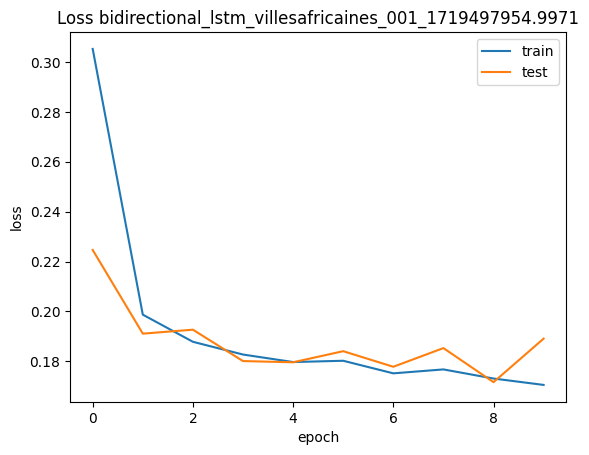

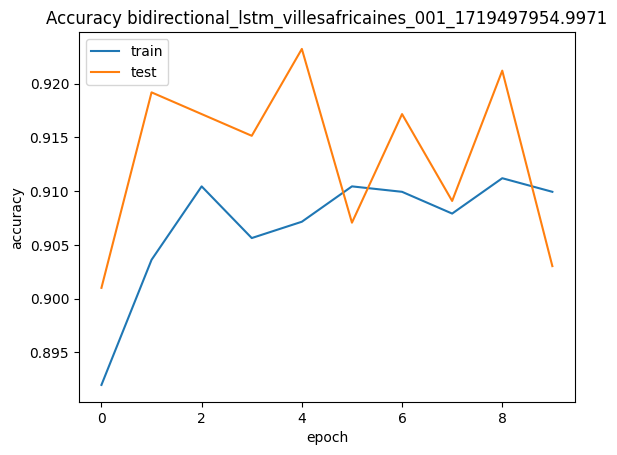

In [28]:
current_timestamp = str(time.time())[:-2]
model=bidirectional_lstm
print(model.__name__)
history, scores = model(x_train, y_train, x_test, y_test, x_val, y_val,week_type, feature_types, course, 
                        num_epochs=10, n_weeks=overwrite_num_weeks, n_features=num_features)
print("{:<15} {:<8} ".format('metric','value'))
for ke, v in scores.items():
    if isinstance(v, float):
        v=round(v, 4)
    if ke!="feature_type":
        print("{:<15} {:<8} ".format(ke, v))
run_name = model.__name__ + "_" + course + "_" + current_timestamp
plot_history(history,run_name)
print(run_name)



## Explainers

In [46]:
import alibi
from alibi.explainers import CEM

In [47]:
bilstm = load_model('models/lstm_bi_'+course+'_cem')


2024-07-04 14:36:30.003070: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-04 14:36:30.003098: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-04 14:36:30.003112: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-04 14:36:30.003197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-04 14:36:30.003245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-04 14:36:30.222626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. You

In [48]:
def pn_all(num_instances,features,feature_names):
    mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
    shape = (1,) + features.shape[1:]  # instance shape
    kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
              # class predicted by the original instance and the max probability on the other classes 
              # in order for the first loss term to be minimized
    beta = .1  # weight of the L1 loss term
    gamma = 100  # weight of the optional auto-encoder loss term
    c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
                # the same class (PP) for the perturbed instance compared to the original instance to be explained
    c_steps = 10  # nb of updates for c
    max_iterations = 1000  # nb of iterations per value of c
    feature_range = (features.min(axis=0),features.max(axis=0)) # feature range for the perturbed instance
    clip = (-1000.,1000.)  # gradient clipping
    lr = 1e-2  # initial learning rate
    no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                    # perturbations towards this value means removing features, and away means adding features
                    # for our MNIST images, the background (-0.5) is the least informative, 
                    # so positive/negative perturbations imply adding/removing features
    cem = CEM(bilstm, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
    gamma = gamma, ae_model=None, max_iterations=max_iterations, 
    c_init = c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)
    changes=[]
    explanations = []
    final_num_instances = []
    for i in num_instances:
        try:
            X = features[i].reshape((1,) + features[0].shape)
            explanation = cem.explain(X)
            change = explanation.PN-X
            print(f'counterfactuals generated for instance {i}')
            changes.append(change)
            explanations.append(explanation)
            final_num_instances.append(i)
        except TypeError:
            print(f'Error occured for instance {i}')
            print(change)
    return explanations, changes, final_num_instances

In [49]:
def pp_all(num_instances,features,feature_names):
    mode = 'PP'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
    shape = (1,) + features.shape[1:]  # instance shape
    kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
              # class predicted by the original instance and the max probability on the other classes 
              # in order for the first loss term to be minimized
    beta = .1  # weight of the L1 loss term
    gamma = 100  # weight of the optional auto-encoder loss term
    c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
                # the same class (PP) for the perturbed instance compared to the original instance to be explained
    c_steps = 10  # nb of updates for c
    max_iterations = 1000  # nb of iterations per value of c
    feature_range = (features.min(axis=0),features.max(axis=0)) # feature range for the perturbed instance
    clip = (-1000.,1000.)  # gradient clipping
    lr = 1e-2  # initial learning rate
    no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                    # perturbations towards this value means removing features, and away means adding features
                    # for our MNIST images, the background (-0.5) is the least informative, 
                    # so positive/negative perturbations imply adding/removing features
    cem = CEM(bilstm, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
    gamma = gamma, ae_model=None, max_iterations=max_iterations, 
    c_init = c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)
    changes=[]
    for i in num_instances:
        try:
            X = features[i].reshape((1,) + features[0].shape)
            explanation = cem.explain(X)
            change = explanation.PP-X
            print(f'counterfactuals generated for instance {i}')
            changes.append(change)
        except TypeError:
            print(f'Error occured for instance {i}')
            print(change)
    return changes

In [34]:
# samples_id=pd.read_csv("data/representative_samples.csv")

# # Select only the "user_id" column
# samples = np.array(samples_id['user_id'])
# samples

# # Load the mapping file
# mapping = pd.read_csv("data/user_id_mapping-dsp_001.csv")

# # Filter the DataFrame based on the user_id values in instances
# filtered_mapping = mapping[mapping['user_id'].isin(samples)]

# # Get the indices and save them as a new list
# instances = filtered_mapping.index.tolist()
# instances

In [50]:
############################################## CODE TO GET THE INDICES OF THE FEATURES
# I pick any feature set here and take the indices that are not easy fail
index=pd.read_csv("../easy-fail/eq_week-chen_cui-" + str(course) + "/feature_labels.csv",)
index

# Make the index a column called 'feature_index'
index.reset_index(inplace=True)
index.rename(columns={'index': 'feature_index'}, inplace=True)

# Rename 'Unnamed: 0' to 'original_index'
index.rename(columns={'Unnamed: 0': 'original_index'}, inplace=True)

# Remove the other columns except 'feature_index' and 'original_index'
index = index[['feature_index', 'original_index']]

samples_id=pd.read_csv("data/"+str(course) + "_sample_5.csv")
samples_id

# USE THIS INDEX MAPPING TO GET THE INDEX IN THE FEATURES
index_mapping = dict(zip(index['original_index'], index['feature_index']))
index_mapping

samples_id=pd.read_csv("data/"+str(course) + "_sample_5.csv")

samples_id['feature_index'] = samples_id['original_index'].map(index_mapping)

instances=samples_id['feature_index'].values
assert np.all(instances < features.shape[0])

In [51]:
instances

array([291, 243, 138, 174, 234])

In [55]:
t1 = time.time()
print('start time', t1)
explanation, changes, final_num_instances = pn_all(instances,features,feature_names)
t2 = time.time()
print('end time', t2)
print(f'time taken: {(t2-t1)/60.0} minutes')

start time 1720096630.8738182


2024-07-04 14:37:11.036076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:37:11.771239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:37:11.981988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:37:12.010009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:37:12.046317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:37:13.815458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:37:13.905878: I tensorflow/core/grappler/optimizers/cust

counterfactuals generated for instance 226
end time 1720097345.048098
time taken: 11.902904665470123 minutes


In [56]:
final_instances = features[final_num_instances]

path = 'uniform_eq_results/CEM/'+course
if not os.path.exists(path):
        os.makedirs(path)
        
np.save('uniform_eq_results/CEM/'+course+'/changes_pn', np.array(changes).reshape(len(final_num_instances),-1))

In [57]:
pns = np.array([explanation[i].PN for i in range(len(explanation))]).reshape(len(final_num_instances),-1)
np.save('uniform_eq_results/CEM/'+course+'/pns', pns)

In [58]:
np.save('uniform_eq_results/CEM/'+course+'/instances', final_instances)

In [59]:
sds = pd.DataFrame(features, columns=feature_names).describe()
sds = sds.loc[:,~sds.columns.duplicated()]
sds = sds.loc['std',:]

In [60]:
np.array(changes).shape


(1, 1, 180)

In [61]:
sds

regularity_peak_dayhour_InWeek1      0.094917
regularity_periodicity_m1_InWeek1    0.146382
delay_lecture_InWeek1                0.263518
total_clicks_InWeek1                 0.099547
number_sessions_InWeek1              0.172027
                                       ...   
competency_anticipation_InWeek5      0.046984
content_alignment_InWeek5            0.046984
content_anticipation_InWeek5         0.046984
student_speed_InWeek5                0.178595
student_shape_InWeek5                0.046984
Name: std, Length: 180, dtype: float64

In [62]:
diffs = pd.DataFrame(np.array(changes).reshape(len(final_num_instances),-1), columns=feature_names)
diffs = diffs.loc[:,~diffs.columns.duplicated()]

for col in diffs.columns:
    diffs[col] = np.abs(diffs[col]*(sds[col]))


In [63]:
diffs.insert(0, 'exp_num', final_num_instances)
diffs.head()

/var/folders/rq/nzqjmf0x07vg4p477yrb9w800000gn/T/ipykernel_73756/2799255352.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diffs.insert(0, 'exp_num', final_num_instances)


,exp_num,regularity_peak_dayhour_InWeek1,regularity_periodicity_m1_InWeek1,delay_lecture_InWeek1,total_clicks_InWeek1,number_sessions_InWeek1,time_sessions_sum_InWeek1,time_sessions_mean_InWeek1,time_between_sessions_std_InWeek1,time_sessions_std_InWeek1,...,pause_duration_std_InWeek5,time_speeding_up_mean_InWeek5,time_speeding_up_std_InWeek5,competency_strength_InWeek5,competency_alignment_InWeek5,competency_anticipation_InWeek5,content_alignment_InWeek5,content_anticipation_InWeek5,student_speed_InWeek5,student_shape_InWeek5
0,226,5.931652e-11,1.012269e-10,7.309326e-09,2.328139e-10,5.838702e-10,2.020548e-10,3.439863e-10,0.0,0.000616,...,1.358201e-09,0.000209,4.236148e-09,0.0,0.0,0.0,0.0,0.001051,2.225482e-11,0.0


In [64]:
diffs.to_csv('uniform_eq_results/CEM/'+course+'/importances.csv')
